# Import relevant packages

In [1]:
import exportCSV #exports data and metadata
import NPC 
import NPC_plotting
import json
import numpy as np

In [2]:
%matplotlib widget

## Specify directory in which to export data

In [3]:
data_dir = '/home/maria/Documents/NPCPython/deletemedata2/' # Directory for output files

## Select config file for simulation settings

In [4]:
config = 'config.yaml'

In [5]:
var = NPC.getVars(config)

## Optional: inspect simulation variables before editing its entries

In [6]:
print(json.dumps(var, indent = 4))

{
    "rel": false,
    "rvar": {
        "rnew": null,
        "rsigma": null
    },
    "thetavar": {
        "thetanew": null,
        "thetasigma": null
    },
    "dvar": {
        "dnew": null,
        "dsigma": null
    },
    "symmet": 8,
    "kappa": null,
    "shiftsigma": null,
    "elliptvar": {
        "elliptnew": null,
        "elliptsigma": null
    },
    "mag": 0,
    "zmag": 0,
    "sigmamult": 0.5,
    "nConnect": 2,
    "damp": 1,
    "kr": 0.7,
    "tlast": 20,
    "step": 0.25
}


# Update simulation variables

In [7]:
var["n"] = 9 # Number of NPCs to be simulated
NPCi = 0 # index out of n of NPC to be shown in any detail-plot or animation. 0-indexed.  
var["seed"] = 51234 #seed for reproducibility. Any number but 0

var["nup"] = ("nup107",) # tuple of Nups to be simulated
var["term"] = ("C",) # Nup terminus for selection. Order should correspond to order of Nups to be simulated
var["model"] = "7r5k"


# ############################
# # Variability parameters
var["mag"] = 15 # Magnitude of irregular variability. 0: No deformation, 15: Strong deformation
var["zmag"] = var["mag"]/2 # magnitude of offset in z. Not computed via springs 


if type(var["nup"]) == str: var["nup"] = tuple([var["nup"]])
if type(var["term"]) == str: var["term"] = tuple(["term"])


## Get a dictionary of all simulated NPCs. 

This includes information on timesteps

In [8]:
NPCs = NPC.getNPCs(var) # Dictionary of all simulated NPCs

/home/maria/Documents/NPCpy/NPCpy/DeformNPC.py:260: RuntimeWarning: invalid value encountered in divide
  return K/Lscale
/home/maria/Documents/NPCpy/NPCpy/DeformNPC.py:260: RuntimeWarning: invalid value encountered in divide
  return K/Lscale


In [9]:
print(NPCs.keys())

dict_keys(['NPCs', 'nupIndex', 'sigmamult', 'zexp', 'fcoords', 'rexp', 'ringAnglesExp', 'ringAngles_corrected', 'elliptical', 'fmags', 'nConnect', 'thetaold', 'newthetas', 'theta_offset', 'zoffsets', 'nuclear_side_boolean', 'isnuc', 'ringmemall', 'ringmember', 'z_i_all'])


## Extract coordinates from NPCs. 
rows are x, y, z, nup index, NPC index. 

nup index specifies the nup: Always 0 in single-channel simulations 

NPC index specifies the NPC out of n

In [10]:
NPCscoords = NPC.getNPCcoords(NPCs, var) 

In [11]:
print(NPCscoords)

[[ 38.53593396  27.6496953   50.11282081   0.           0.        ]
 [ 11.58685307  56.45792189  49.80666467   0.           0.        ]
 [-30.2388597   52.45832557  54.18613807   0.           0.        ]
 ...
 [-56.68832345 -28.33836818   6.1996651    0.           8.        ]
 [-18.4660973  -49.42031407   1.06471496   0.           8.        ]
 [ 23.1752035  -49.80414661   7.25681385   0.           8.        ]]


## Arrange NPCs on a grid
NPCscoords contains relative coordinates, i.e. NPCs are more or less 0-centred. 

They would overlap if plotted. 

OffsetNPCs arranges these NPCs on a grid using a given offset

In [12]:
offset = 1.5 * np.mean(NPCs["rexp"]) # set offset to 1.5 * the expected NPC radius 
OffsetNPCs = NPC_plotting.OffsetNPCs(NPCscoords, offset)

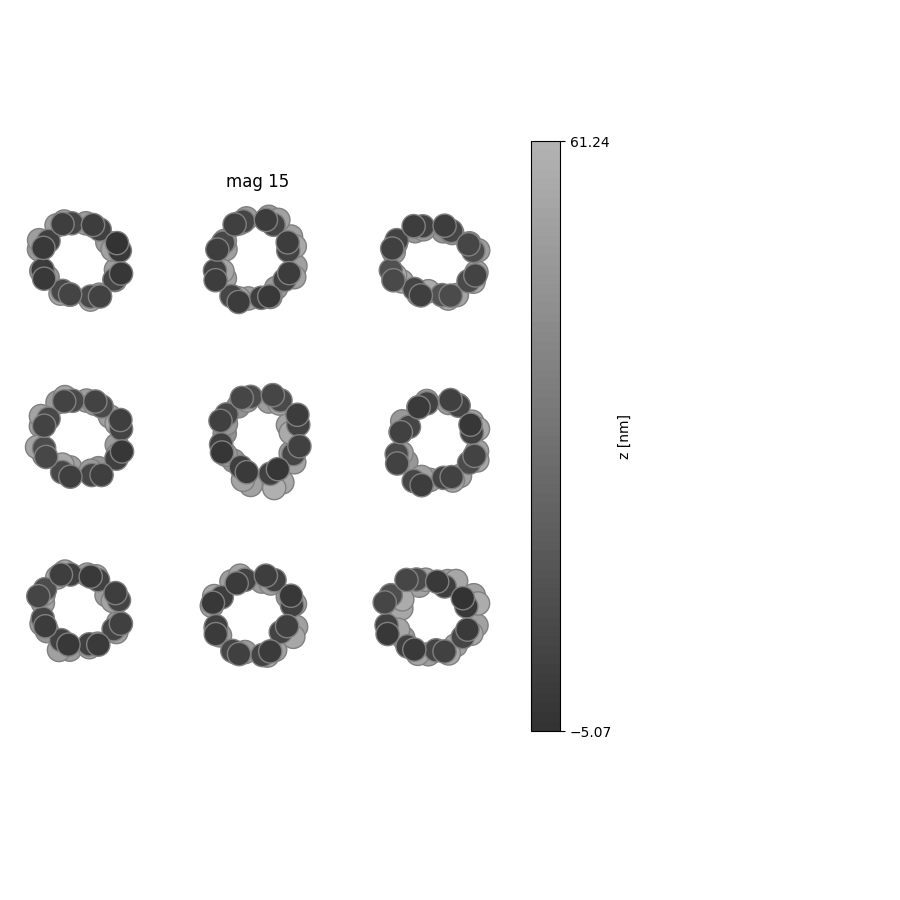

In [20]:
NPC_plotting.plotOverview(OffsetNPCs, NPCs, var, width = 9)

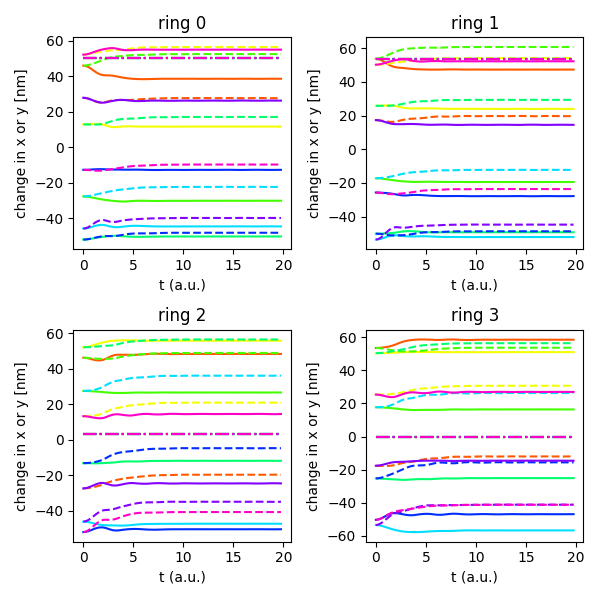

In [14]:
NPC_plotting.positionVStime(NPCs, NPCi)

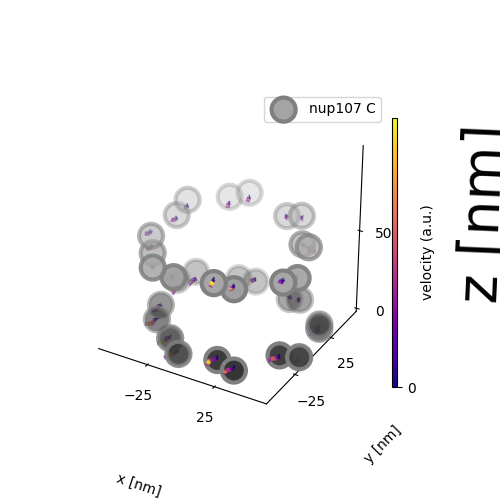

In [15]:
NPC_plotting.plotDetail(NPCscoords, NPCs, var, NPCi, width = 5)

In [16]:
#NPC_plotting.AnimateDetail(NPCs, var, NPCi)

In [17]:
#NPC_plotting.AnimateOverview(NPCs, OffsetNPCs, var)

In [18]:
nameDict, name = exportCSV.names(var)
exportCSV.MakeCSV(var, NPCstest, NPCscoords, nameDict, name, data_dir) 

NameError: name 'NPCstest' is not defined